# Need to run automatic lfilter as pbs job

In [2]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
# import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client
import xrft


def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

<Client: 'tcp://127.0.0.1:35747' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35747,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:41479,Total threads: 4
Dashboard: /proxy/45879/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40039,


## Plot more polished spectra of Kinetic Energy

**Inputs:** t0, time window, region. Rectangle either in generation, propagation, shoaling or eddy-box (subset of shoaling)

1. Calculate KE in region of interest
2. Average spatially
3. Plot power spectrum. 
4. Plot with $\omega$ multipled through on y axis


In [9]:
def plot_power_spectrum(data,ax,color,label = None,linestyle = "solid"):

    u = xrft.power_spectrum(data.u, dim=['time'], window='hann',true_phase = True,detrend = "linear")
    v = xrft.power_spectrum(data.v, dim=['time'], window='hann',true_phase = True,detrend = "linear")
    ps = 0.5*(u + v)


    m2 = 1 / (12.45 * 3600)
    f = 1 / (17.89 * 3600)

    if "xb" in ps.dims:
        ps = ps.mean("xb")
    if "yb" in ps.dims:
        ps = ps.mean("yb")
    if "zl" in ps.dims:
        ps = ps.mean("zl")
    if label != None:
        (ps.freq_time * ps).plot(xscale = "log",yscale = "log",ax = ax,color = color,label = label,linestyle = linestyle)
    else:
        (ps.freq_time * ps).plot(xscale = "log",yscale = "log",ax = ax,color = color,linestyle = linestyle)
    # ps.plot(ax = ax)

    return 

def get_KE_data(s,timeslice =200,zrange = (10,30)):
    """
    Given a dictionary s of experiment names, such that 
    s[i] = {"expt":"full-20","time":t0}
    return a dictionary of data for each of these combinations
    This can later be split up into the regions of interest
    """
    data = {}
    for i in s:
        vels = tt.collect_data(
            s[i]["expt"],
            rawdata = ["u","v"],timerange = (s[i]["time"] - timeslice,s[i]["time"] + timeslice)).sel(yb = slice(-50,50))
        vels = vels.assign_coords({"time":vels.time * 3600}).chunk({"time":-1,"zl":1})
        
        data[i] = vels.fillna(0) #! Fillna necessary for detrend to work in shelf region where there's shallow bathy. This might mess up averages though!

    return data

#TODO Combine these two functions
def get_lfiltered_data(s):
    """
    Given a dictionary s of experiment names, such that 
    s[i] = {"expt":"full-20","time":t0}
    return a dictionary of data for each of these combinations
    This can later be split up into the regions of interest
    """
    data = {}
    for i in s:
        vels = xr.open_mfdataset(
            f"/g/data/nm03/ab8992/postprocessed/{s[i]['expt']}/lfiltered/t0-{s[i]['time']}/*.nc",
            decode_times = False,
            decode_cf = False,
            parallel = True)
        vels = vels.assign_coords({"time":vels.time * 3600}).chunk({"time":-1})

        data[i] = vels

    return data




def ps_tidyup(ax,title):
    """
    Add M2 and f lines to a power spectrum plot
    """

    m2 = 1 / (12.45 * 3600)
    f = 1 / (17.89 * 3600)

    maxi = 1e-2

    ax.vlines(m2,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.vlines(m2 + f,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.vlines(2 * m2,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.vlines(f,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.vlines(2 * f,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel(r"$\omega$KE per frequency")
    # Instead of using labels, put the text of M2 f ect on the plot near the x axis
    ax.text(1.01 * m2,1.1 * 1e-10,"M2")
    ax.text(0.99 * m2 + f,1.1 * 1e-10,"M2+f")
    ax.text(1.01 * f,1.1 * 1e-10,"f")
    ax.text(1.01 * 2 * f,1.1 * 1e-10,"2f")
    ax.text(1.01 * 2 * m2,1.1 * 1e-10," 2M2")

    ax.set_title(title)
    return 

def SelectRegion(data,region):
    data = data.sel(xb = slice(regions[region][0],regions[region][1]))
    return data

regions = {"gen": [1300,None],"prop": [700,800],"eddy": [200,250],"shelf": [100,150]}


## Get the data to compare for 20th and 40th degree. 
Here we just take a single time for both. Later, compare eddy and no eddy

In [10]:

## Intentionally choose times with no eddies for now
ToCompare20 = {
    "No Tide 20":{
        "expt":"notide-20",
        "time":44900
    },
    "Blank 20":{
        "expt":"blank-20",
        "time":60 * 24
    },
    "Tide 20":{
        "expt":"full-20",
        "time":38000
    }
}

ToCompare40 = {
    "No Tide 40":{
        "expt":"notide-40",
        "time":20000
    },
    "Blank 40":{
        "expt":"blank-40",
        "time":60 * 24
    },
    "Tide 40":{
        "expt":"full-40",
        "time":20000
    }
}

data_20 = get_KE_data(ToCompare20)
data_40 = get_KE_data(ToCompare40)

loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.


## Compare 20th degree experiments away from eddy

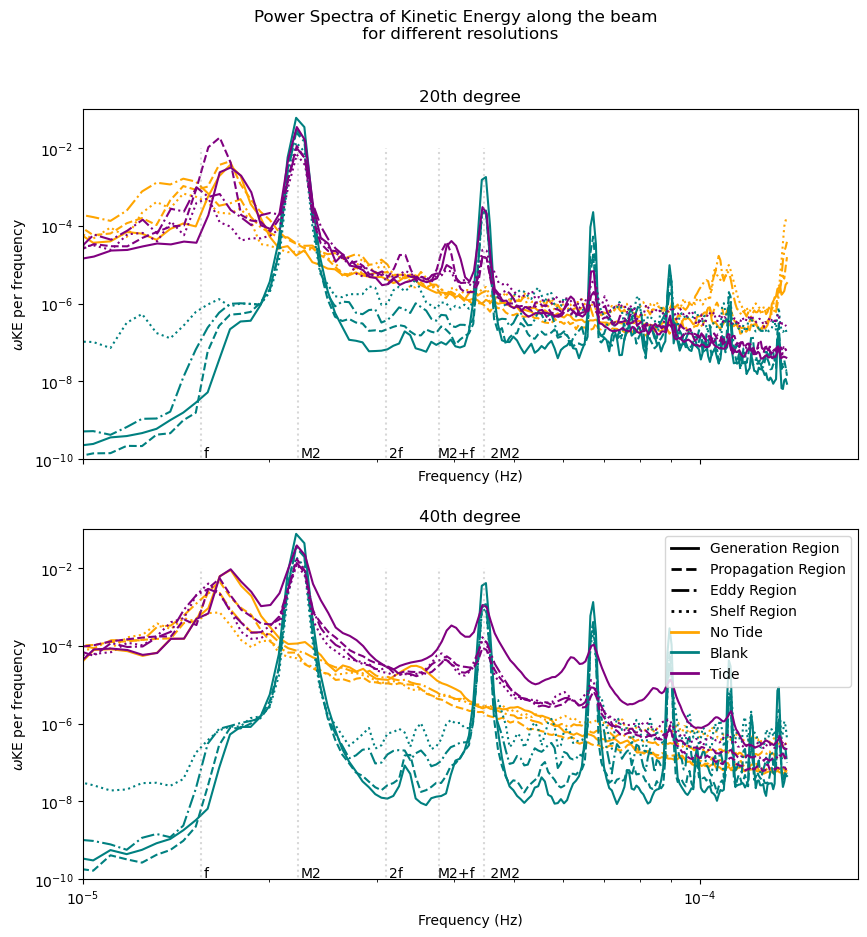

In [11]:
fig,ax = plt.subplots(2,1,figsize = (10,10),sharex=True)
from matplotlib.lines import Line2D

cmap = plt.get_cmap('Dark2')
colours = ["orange","teal","purple"]

legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='Generation Region'),
    Line2D([0], [0], color="black", linestyle="dashed",lw=2, label='Propagation Region'),
    Line2D([0], [0], color="black", linestyle="dashdot",lw=2, label='Eddy Region'),
    Line2D([0], [0], color="black", linestyle="dotted",lw=2, label='Shelf Region'),
]

for i,data in enumerate([data_20,data_40]):
    for j,d in enumerate(data):
        # Loop over each data selection
        KE = data[d]
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"gen"),ax[i],colours[j])
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"prop"),ax[i],colours[j],linestyle = "dashed")
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"eddy"),ax[i],colours[j],linestyle = "dashdot")
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"shelf"),ax[i],colours[j],linestyle = "dotted")
        if i == 0:
            legend_elements.append(Line2D([0], [0], color=colours[j], lw=2, label=d.split(" 20")[0]))

ax[0].set_xlim(1e-5,None)
ax[0].set_ylim(1e-10,1e-1)
ax[1].set_ylim(1e-10,1e-1)
ax[1].legend(handles=legend_elements,loc = "upper right")
fig.suptitle("Power Spectra of Kinetic Energy along the beam \n for different resolutions")
ps_tidyup(ax[0],"20th degree")
ps_tidyup(ax[1],"40th degree")




# Compare just the shelf region when eddy is present and not present

In [6]:

## Select data to compare for these two plots
eddypresent = {
    "No Tide 20":{
        "expt":"notide-20",
        "time":38000
    },
    "Tide 20":{
        "expt":"full-20",
        "time":44900
    },
    "No Tide 40":{
        "expt":"notide-40",
        "time":8100
    },
    "Tide 40":{
        "expt":"full-40",
        "time":5140
    },
}

eddyabsent = {
    "No Tide 20":{
        "expt":"notide-20",
        "time":25700
    },
    "Tide 20":{
        "expt":"full-20",
        "time":62655
    },
    "No Tide 40":{
        "expt":"notide-40",
        "time":6000
    },
    "Tide 40":{
        "expt":"full-40",
        "time":6480
    },
}

EddyPresent = get_KE_data(eddypresent)
EddyAbsent = get_KE_data(eddyabsent)

loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.


## Compare 20th degree experiments away from eddy

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecat

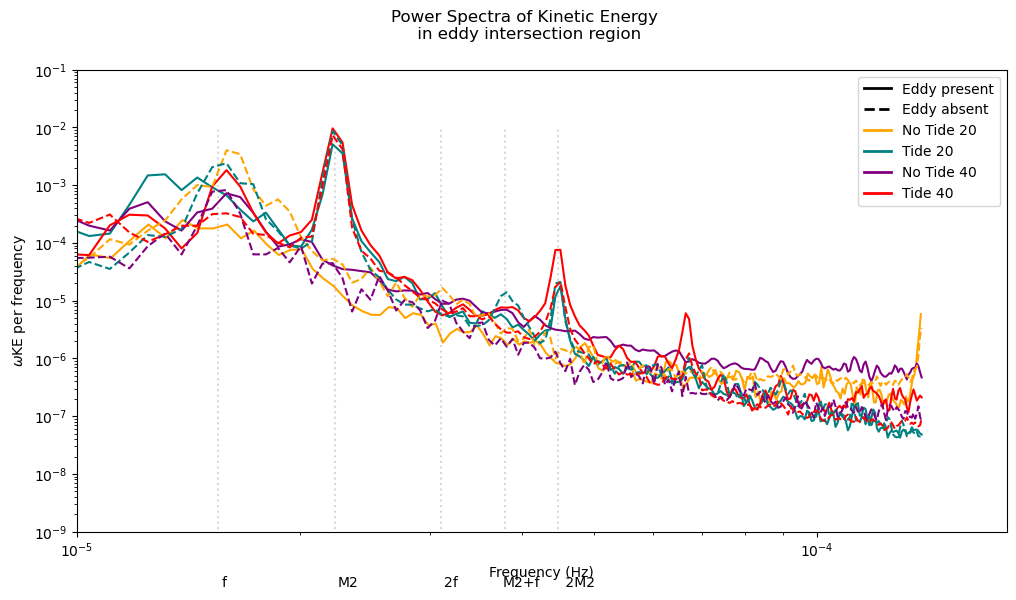

2024-04-10 00:14:37,656 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:46791'.
2024-04-10 00:14:37,658 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43349'.
2024-04-10 00:14:37,656 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis

In [7]:
fig,ax = plt.subplots(1,figsize = (12,6))
from matplotlib.lines import Line2D

colours = ["orange","teal","purple","red"]
linestyles = ["solid","dashed"]
legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='Eddy present'),
    Line2D([0], [0], color="black", linestyle="dashed",lw=2, label='Eddy absent'),
]

for i,data in enumerate([EddyPresent,EddyAbsent]):
    for j,d in enumerate(data):
        # Loop over each data selection
        KE = data[d]
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"eddy"),ax,colours[j],linestyle = linestyles[i])

        if i == 0:
            legend_elements.append(Line2D([0], [0], color=colours[j], lw=2, label=d))

ax.set_xlim(1e-5,None)
ax.set_ylim(1e-9,1e-1)
ax.legend(handles=legend_elements,loc = "upper right")
fig.suptitle("Power Spectra of Kinetic Energy \n in eddy intersection region")
ps_tidyup(ax,"")
# ps_tidyup(ax,"Eddy Absent")




# Plot spectra from Lagrange filtered outputs

In [37]:

lfiltered = {
    "No Tide 20":{
        "expt":"notide-20",
        "time":25700
    },
    "Tide 20":{
        "expt":"full-20",
        "time":62655
    }
}

raw = {
    "No Tide 20":{
        "expt":"notide-20",
        "time":25700
    },
    "Tide 20":{
        "expt":"full-20",
        "time":62655
    }
}

lfiltered = get_lfiltered_KE_spectrum(lfiltered)
raw = get_KE_spectrum(raw)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecat

loading u...	done.
loading v...	done.
loading u...	

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


done.
loading v...	done.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


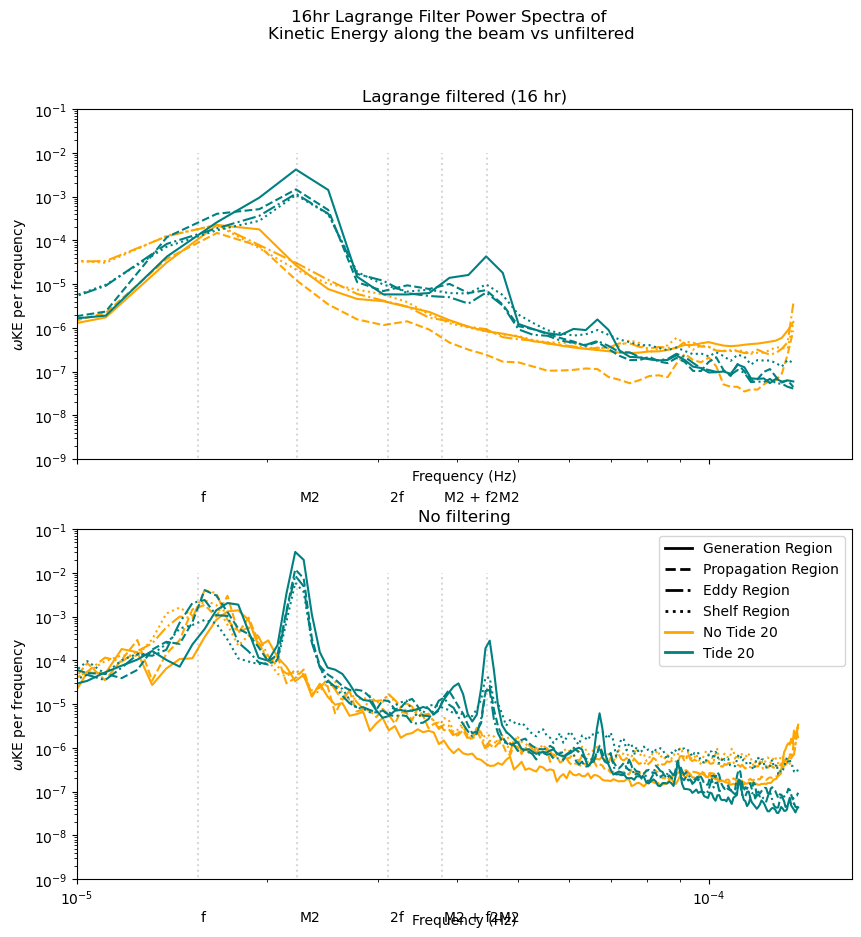

In [39]:
fig,ax = plt.subplots(2,1,figsize = (10,10),sharex=True)
from matplotlib.lines import Line2D

cmap = plt.get_cmap('Dark2')
colours = ["orange","teal","purple"]

legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='Generation Region'),
    Line2D([0], [0], color="black", linestyle="dashed",lw=2, label='Propagation Region'),
    Line2D([0], [0], color="black", linestyle="dashdot",lw=2, label='Eddy Region'),
    Line2D([0], [0], color="black", linestyle="dotted",lw=2, label='Shelf Region'),
]

for i,data in enumerate([lfiltered,raw]):
    for j,d in enumerate(data):
        # Loop over each data selection
        KE = data[d]
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"gen"),ax[i],colours[j])
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"prop"),ax[i],colours[j],linestyle = "dashed")
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"eddy"),ax[i],colours[j],linestyle = "dashdot")
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(0,20)),"shelf"),ax[i],colours[j],linestyle = "dotted")
        if i == 0:
            legend_elements.append(Line2D([0], [0], color=colours[j], lw=2, label=d))

ax[0].set_xlim(1e-5,None)
ax[0].set_ylim(1e-9,1e-1)
ax[1].set_ylim(1e-9,1e-1)
ax[1].legend(handles=legend_elements,loc = "upper right")
fig.suptitle("16hr Lagrange Filter Power Spectra of \nKinetic Energy along the beam vs unfiltered")
ps_tidyup(ax[0],"Lagrange filtered (16 hr)")
ps_tidyup(ax[1],"No filtering")


